# Gradient Descent: Algorithms, Pitfalls, and Practical Insights

In this notebook, we explore gradient descent, its classic pitfalls, and how each major variant improves on the last. The notes throughout consist of concrete examples and visualisations.

---

Gradient descent methods are usually categorized along two independent axes:

**1. The Optimization Algorithm**: How does each step update the parameters? Examples: Basic (Batch) Gradient Descent, Momentum, AdaGrad, RMSProp, Adam, L-BFGS

**2. The Data Usage per Update**: How much data is used to compute the gradient at each step? Examples: Basic (Batch) Gradient Descent, Stochastic (SGD), Mini-batch Gradient Descent

---

Most practical machine learning uses an *optimizer algorithm* in combination with *mini-batch* data usage.

## 0. Prerequisite Knowledge

This notebook assumes you are comfortable with the following core concepts:

---

### **Functions and Their Plots**

- A function $f$ maps input values $x$ to output values $f(x)$.
- We frequently plot functions to visualise their "shape", especially around where the minimum and maximum are.

---

### **Derivatives and Gradients**

- The **derivative** of a function tells us how fast it changes, i.e. its slope. For example, the derivative of $f(x) = x^2$ is $f'(x) = 2x$.
- The **gradient** is the generalization of the derivative to functions of multiple variables. For example gradient $\nabla f(x, y)$ points in the direction of steepest ascent.

---

### **Optimization and Minima**

- **Optimization** means finding the value(s) of the parameter(s) that **minimizes or maximizes a function**.
- A **minimum**/**maximum** is a point where the function is as small/large as possible (locally or globally).

---

### **Loss Functions**

- While not strictly necessary prerequisite knowledge, a common modern usage of optimization appears in the context of training a model.
- In this context, we define a **loss function** $\mathcal{L}(y)$ (or "cost") that measures how far a model's predictions are from the correct answers, where the model is defined by $y=f(x;\theta)$, with **inputs** $x$, **outputs** $y$, and **parameters** $\theta$.
- The goal is to **find the minimum** of this loss function.

For simplicity, we remove this context by using $f$ throughout to represent our function to be optimized.

---

### **Basic Python/NumPy/Matplotlib**

- Familiarity with basic Python syntax will help.
- We also use NumPy (for math/arrays), and Matplotlib (for plotting).

---


## 1. Basic (Batch) Gradient Descent

Gradient descent is an iterative optimization algorithm for finding the minimum of a function $f$. The basic algorithm is:
1. Initialise with some starting point $x_0$.
2. Compute the gradient of the function $\nabla f$.
3. Set $x_{k+1} = x_k - \eta \nabla f(x_k)$, for some $k \in \mathbb{Z}^+$ and learning rate $\eta \in \mathbb{R}^+$.
4. Repeat from 2. for a set number of steps.

The key to this algorithm is the update rule:

$$x_{k+1} = x_k - \eta \nabla f(x_k)$$

We will see that variants will have a different update rule. We will also see throughout the following key problems with gradient descent algorithms:
- Learning rate. Too large may overshoot the minimum, diverge, or bounce chaotically. Too small will converge very slowly, and possibly be stuck in plateaus or saddle points.
- Starting location. Starting too close to a saddle point or local minima may result in being stuck there. Starting too far away may lead to exploding gradients where the loss grows rapidly (e.g. $e^x$ or $x^8$).

Variants attempt to solve these by:
- Altering the learning rate over the training. A nice idea is that a large learning rate is good at the start of training to quickly move to areas of interest, and then a small learning rate towards the end to aid with convergence.
- Adding momentum. A nice idea is that momentum helps the algorithm follow the overall trend of the loss surface, rather than be distracted by small local minima. This is because momentum smooths out short-term fluctuations by becoming a moving average of recent gradients.

---

Consider the following simple quadratic:

$$
f(x) = (x-3)^2
$$

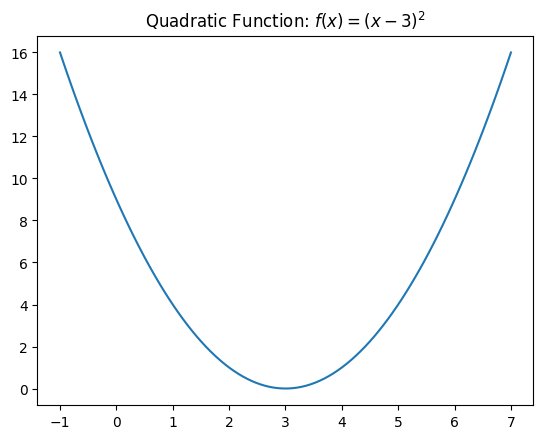

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function setup
def quad_f(x):
    return (x - 3)**2

def quad_grad(x):
    return 2 * (x - 3)

# Function plot
x = np.linspace(-1, 7, 100)
plt.plot(x, quad_f(x))
plt.title("Quadratic Function: $f(x) = (x-3)^2$")
plt.show()

Running gradient descent starting at $x = 0$ gives the following path:

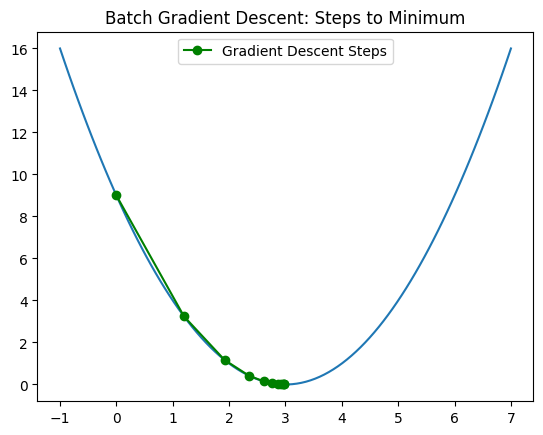

In [2]:
# Parameter setup
x_k = 0.0
eta = 0.2

# Gradient descent run
history = [x_k]
for _ in range(10):
    x_k = x_k - eta * quad_grad(x_k)
    history.append(x_k)

# Gradient descent path plot
plt.plot(x, quad_f(x))
plt.plot(history, quad_f(np.array(history)), "go-", label="Gradient Descent Steps")
plt.title("Batch Gradient Descent: Steps to Minimum")
plt.legend()
plt.show()

### Pitfall 1: Slow Progress in Plateaus

On functions with flat regions, gradient descent can take tiny steps and get "stuck".

Consider the following example of a "plateau" function:

$$
f(x) = \tanh(x) + 0.01x
$$

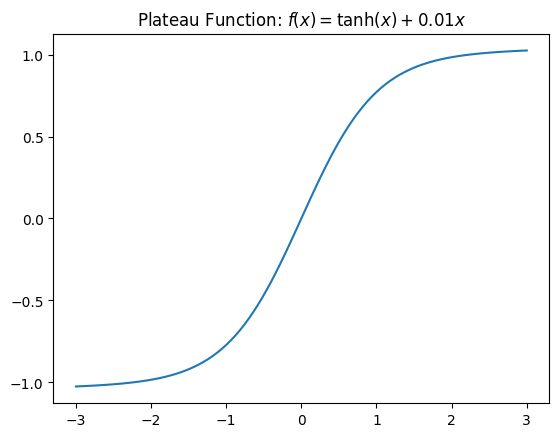

In [3]:
# Function setup
def plateau_f(x):
    return np.tanh(x) + 0.01 * x

def plateau_grad(x):
    return 1 - np.tanh(x)**2 + 0.01

# Function plot
x = np.linspace(-3, 3, 100)
plt.plot(x, plateau_f(x))
plt.title(r"Plateau Function: $f(x) = \tanh(x) + 0.01x$")
plt.show()

Running gradient descent starting at $x = -2$ gives the following path:

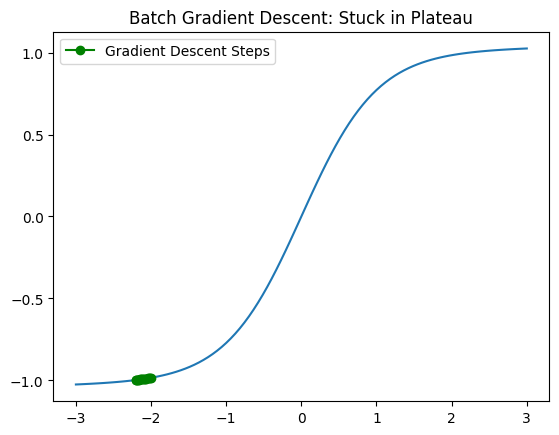

In [4]:
# Parameter setup
x_k = -2.0
eta = 0.2

# Gradient descent run
history = [x_k]
for _ in range(15):
    x_k = x_k - eta * plateau_grad(x_k)
    history.append(x_k)

# Gradient descent path plot
plt.plot(x, plateau_f(x))
plt.plot(history, plateau_f(np.array(history)), "go-", label="Gradient Descent Steps")
plt.title("Batch Gradient Descent: Stuck in Plateau")
plt.legend()
plt.show()

## 2. Momentum

Momentum accumulates past gradients to help escape flat regions/plateaus faster.

Update rule:

\begin{align*}
v_{k+1} &= \beta v_k + \nabla f(x_k) \\
x_{k+1} &= x_k - \eta v_{k+1}
\end{align*}

where:
- $x_k$ is the parameter vector at step $k$
- $\nabla f(x_k)$ is the gradient of $f$ at $x_k$
- $v_k$ is the "velocity" at step $k$, usually initialised with $v_0 = 0$
- $\beta$ is the momentum parameter - this acts as a decay rate for the gradients' "memory" so is usually set to $\beta = 0.9$ so that the effective "memory" is $1/(1-\beta) = 10$
- $\eta$ is the learning rate

---

Considering again the previous "plateau" function with the same gradient descent starting point $x = -2$ gives the following path:

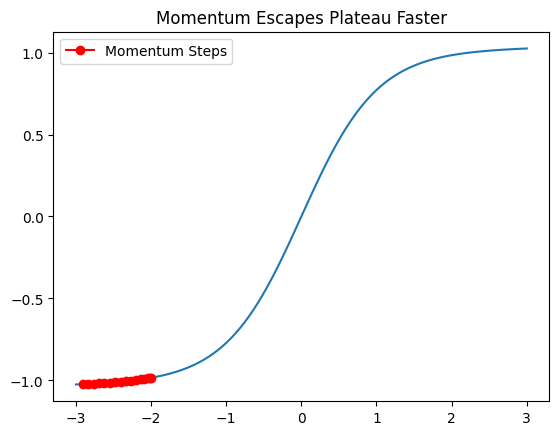

In [5]:
# Parameter setup
x_k = -2.0
v = 0.0
beta = 0.9
eta = 0.2

# Gradient descent run
history = [x_k]
for _ in range(15):
    v = beta * v + plateau_grad(x_k)
    x_k = x_k - eta * v
    history.append(x_k)

# Gradient descent path plot
plt.plot(x, plateau_f(x))
plt.plot(history, plateau_f(np.array(history)), "ro-", label="Momentum Steps")
plt.title("Momentum Escapes Plateau Faster")
plt.legend()
plt.show()

### Pitfall 2: Zig-Zagging in Ravines

Momentum and vanilla GD struggle with functions with steep/narrow valleys.

Consider the following example of a "ravine" function:

$$f(x, y) = 5x^2 + y^2$$

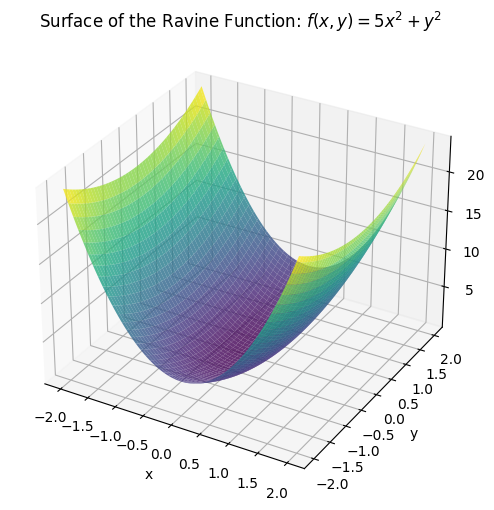

In [6]:
# Function setup
def ravine_f(X):
    x, y = X
    return 5*x**2 + y**2

def ravine_grad(X):
    x, y = X
    return np.array([10*x, 2*y])

# Use a reasonably "zoomed-in" range to see the shape near the minimum
xg, yg = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
zg = ravine_f((xg, yg))

# Function plot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xg, yg, zg, cmap="viridis", alpha=0.8, edgecolor="none")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.set_title("Surface of the Ravine Function: $f(x, y) = 5x^2 + y^2$")
plt.show()

Running gradient descent starting at $(1.5, 1.5)$ gives the following path - notice that updates zig-zag back and forth across the valley walls:

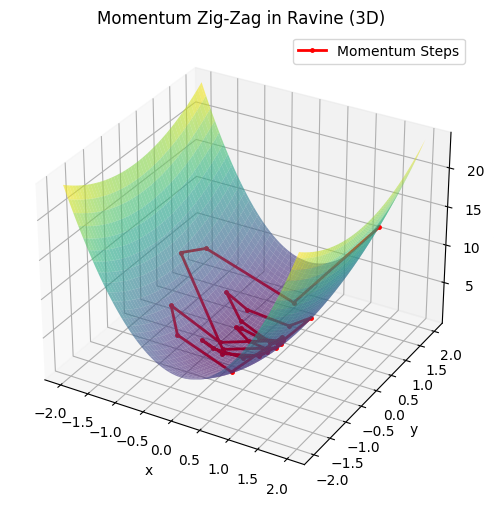

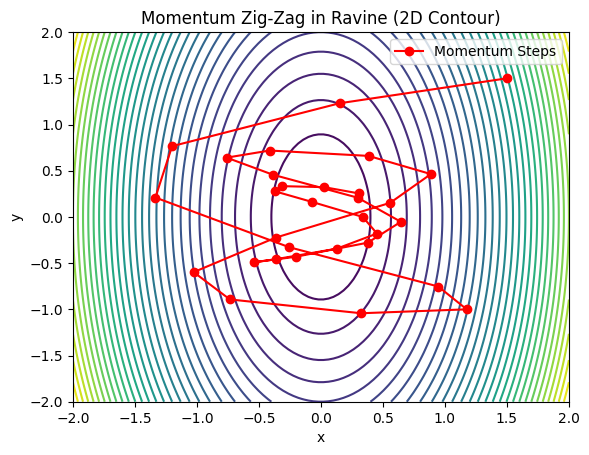

In [7]:
# Parameter setup
pos = np.array([1.5, 1.5])
v = np.zeros(2)
beta = 0.9
eta = 0.09

# Gradient descent run
history = [pos.copy()]
for _ in range(30):
    v = beta * v + ravine_grad(pos)
    pos = pos - eta * v
    history.append(pos.copy())
history = np.array(history)

# Gradient descent path plot on 3D surface
def plot_3d_surface_with_path(xg, yg, zg, path, optimizer_name, title=""):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(xg, yg, zg, cmap="viridis", alpha=0.6, edgecolor="none")
    ax.plot(path[:, 0], path[:, 1], ravine_f((path[:, 0], path[:, 1])),
            "r.-", label=f"{optimizer_name} Steps", linewidth=2, markersize=5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")
    ax.set_title(title)
    # ax.view_init(elev=35, azim=-90) # Optionally adjust to aid with visualisation
    plt.legend()
    plt.show()

plot_3d_surface_with_path(xg, yg, zg, history, optimizer_name="Momentum", title="Momentum Zig-Zag in Ravine (3D)")

# Gradient descent path plot on 2D contour
plt.contour(xg, yg, zg, levels=30)
plt.plot(history[:, 0], history[:, 1], "ro-", label="Momentum Steps")
plt.title("Momentum Zig-Zag in Ravine (2D Contour)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## 3. AdaGrad (Adaptive Gradient)

AdaGrad (Adaptive Gradient) adapts the learning rate for each parameter, reducing zig-zags in ravines.

Update rule:

\begin{align*}
G_t &= G_{t-1} + g_t^2 \\
x_{t+1} &= x_t - \eta \frac{g_t}{\sqrt{G_t} + \epsilon}
\end{align*}

where:
- $x_t$ is the parameter vector at step $t$
- $g_t = \nabla f(x_t)$ is the gradient of $f$ at $x_t$
- $G_t$ is the sum of squares of past gradients up to and including step $t$, usually initialised with $G_0 = 0$
- $\eta$ is the learning rate
- $\epsilon$ is a small constant, usually set to $\epsilon = 10^{-8}$, which exists for numerical stability (i.e. to avoid division by zero or a very small number)

---

Considering again the previous "ravine" function with the same gradient descent starting point $x = (1.5, 1.5)$ gives the following path:

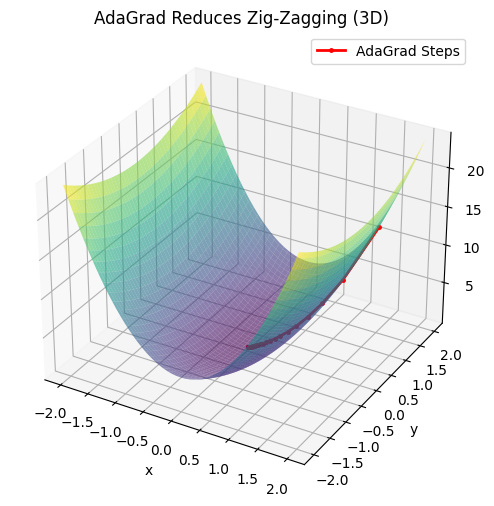

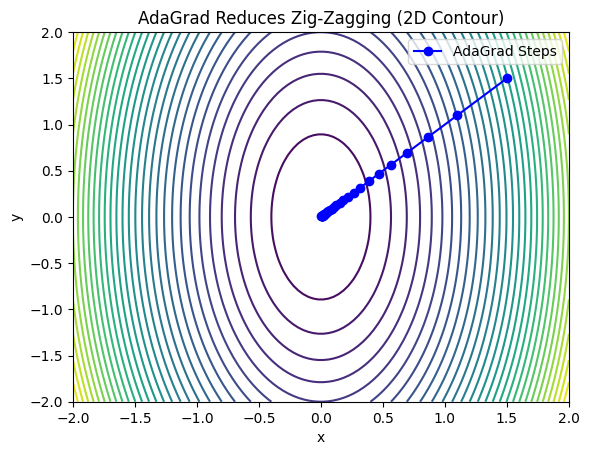

In [8]:
# Parameter setup
pos = np.array([1.5, 1.5])
G = np.zeros(2)
eta = 0.4
eps = 1e-8

# Gradient descent run
history = [pos.copy()]
for _ in range(30):
    g = ravine_grad(pos)
    G += g**2
    pos = pos - eta * g / (np.sqrt(G) + eps)
    history.append(pos.copy())
history = np.array(history)

# Gradient descent path plot on 3D surface
plot_3d_surface_with_path(xg, yg, zg, history, optimizer_name="AdaGrad", title="AdaGrad Reduces Zig-Zagging (3D)")

# Gradient descent path plot on 2D contour
plt.contour(xg, yg, zg, levels=30)
plt.plot(history[:, 0], history[:, 1], "bo-", label="AdaGrad Steps")
plt.title("AdaGrad Reduces Zig-Zagging (2D Contour)")
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel("f(x, y)")
plt.legend()
plt.show()

### Pitfall 3: AdaGrad Stops Learning

AdaGrad's learning rate keeps shrinking. On a long, shallow slope, progress can halt.

Conside the following example of a "flat" function which goes flat as $x \to -\infty$:

$$
f(x) = \log(1 + e^x)
$$

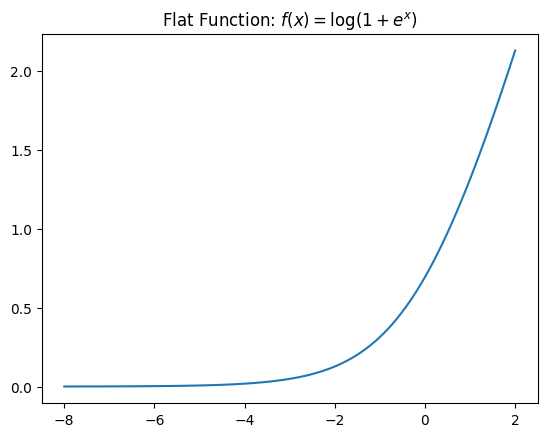

In [9]:
# Function setup
def flat_f(x):
    return np.log(1 + np.exp(x))

def flat_grad(x):
    return 1 / (1 + np.exp(-x))

# Function plot
x = np.linspace(-8, 2, 100)
plt.plot(x, flat_f(x))
plt.title(r"Flat Function: $f(x) = \log(1 + e^x)$")
plt.show()

Running gradient descent starting at $x = -7$ gives the following path:

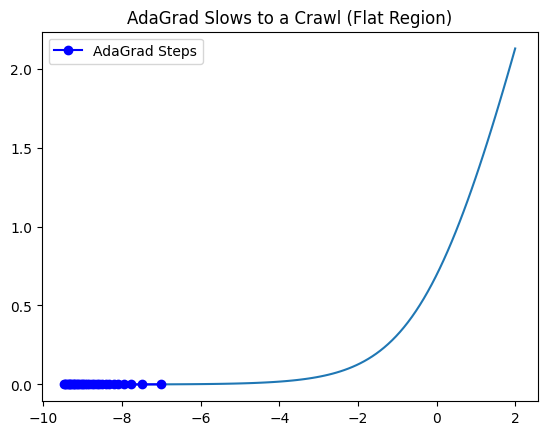

In [10]:
# Parameter setup
x_k = -7.0
G = 0
eta = 0.5
eps = 1e-8

# Gradient descent run
history = [x_k]
for _ in range(30):
    g = flat_grad(x_k)
    G += g**2
    x_k = x_k - eta * g / (np.sqrt(G) + eps)
    history.append(x_k)

# Gradient descent path plot
plt.plot(x, flat_f(x))
plt.plot(history, flat_f(np.array(history)), "bo-", label="AdaGrad Steps")
plt.title("AdaGrad Slows to a Crawl (Flat Region)")
plt.legend()
plt.show()

## 4. RMSProp (Root Mean Squared Propagation)

RMSProp (Root Mean Squared Propagation) fixes AdaGrad's vanishing learning rate by using a moving average of squared gradients.

Update rule:

\begin{align*}
E[g^2]_t &= \beta E[g^2]_{t-1} + (1-\beta)g_t^2 \\
x_{t+1} &= x_t - \eta \frac{g_t}{\sqrt{E[g^2]_t} + \epsilon}
\end{align*}

where:
- $x_t$ is the parameter vector at step $t$
- $g_t = \nabla f(x_t)$ is the gradient of $f$ at $x_t$
- $E[g^2]_t$ is the exponentially weighted moving average (EWMA) of past squared gradients, usually initialised with $E[g^2]_0 = 0$ (or a small positive value)
- $\beta$ is the decay rate, usually set to $\beta = 0.9$ so that the effective "memory" is $1/(1-\beta) = 10$
- $\eta$ is the learning rate
- $\epsilon$ is a small constant, usually set to $\epsilon = 10^{-8}$, which exists for numerical stability (i.e. to avoid division by zero or a very small number)

---

Considering again the previous "flat" function with the same gradient descent starting point $x = -7$ gives the following path:

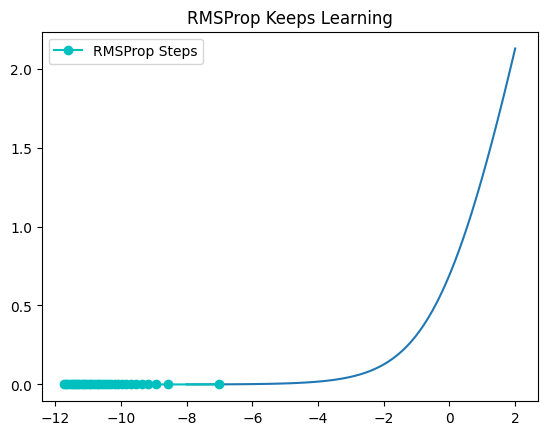

In [11]:
# Parameter setup
x_k = -7.0
Eg2 = 0.0
beta = 0.9
eta = 0.5
eps = 1e-8

# Gradient descent run
history = [x_k]
for _ in range(30):
    g = flat_grad(x_k)
    Eg2 = beta * Eg2 + (1 - beta) * g**2
    x_k = x_k - eta * g / (np.sqrt(Eg2) + eps)
    history.append(x_k)

# Gradient descent path plot
plt.plot(x, flat_f(x))
plt.plot(history, flat_f(np.array(history)), "co-", label="RMSProp Steps")
plt.title("RMSProp Keeps Learning")
plt.legend()
plt.show()

### Pitfall 4: RMSProp Can Be Sensitive to Hyperparameters

- RMSProp's moving average needs tuning of $\beta$ and $\eta$.
- It can still be unstable on some functions, such as when gradients are very sparse and momentum is required to "carry" updates, or when the gradient statistics change very rapidly which causes the moving average to lag behind.

Consider the following example of an "oscillating" function:

$$
f(x) = 0.1x + \sin(5x)
$$

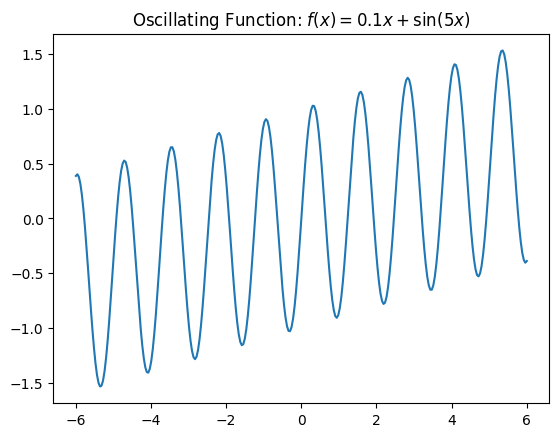

In [12]:
# Function setup
def oscillating_f(x):
    return 0.1*x + np.sin(5*x)

def oscillating_grad(x):
    return 0.1 + 5*np.cos(5*x)

# Function plot
x = np.linspace(-6, 6, 300)
plt.plot(x, oscillating_f(x))
plt.title("Oscillating Function: $f(x) = 0.1x + \sin(5x)$")
plt.show()

Running gradient descent starting at $x = -5$ gives the following path:

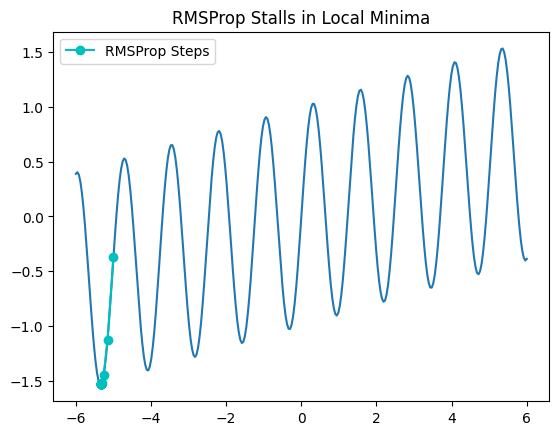

In [13]:
# Parameter setup
x_k = -5
Eg2 = 0.0
beta = 0.9
eta = 0.05
eps = 1e-8

# Gradient descent run
history = [x_k]
for _ in range(30):
    g = oscillating_grad(x_k)
    Eg2 = beta * Eg2 + (1 - beta) * g**2
    x_k = x_k - eta * g / (np.sqrt(Eg2) + eps)
    history.append(x_k)

# Gradient descent path plot
plt.plot(x, oscillating_f(x))
plt.plot(history, [oscillating_f(xx) for xx in history], "co-", label="RMSProp Steps")
plt.legend()
plt.title("RMSProp Stalls in Local Minima")
plt.show()

## 5. Adam (Adaptive Moment Estimation)

Adam (Adaptive Moment Estimation) combines momentum and RMSProp for faster, more stable convergence, and is hence more robust than either optimizer individually.

Update rule:


\begin{align*}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) g_t \quad&\text{(first moment: momentum)} \\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) g_t^2 \quad&\text{(second moment: RMSProp)} \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \quad&\text{(bias-corrected first moment)} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \quad&\text{(bias-corrected second moment)} \\
x_{t+1} &= x_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} \quad&\text{}
\end{align*}

where:
- $x_t$ is the parameter vector at step $t$
- $g_t = \nabla f(x_t)$ is the gradient of $f$ at $x_t$
- $m_t$ is the exponentially weighted moving average of gradients (i.e. the "first moment" - captures the trend/momentum of gradients to smooth out updates), usually initialised with $m_0 = 0$
- $v_t$ is the exponentially weighted moving average of squared gradients (i.e. the "second moment" - adapts the step size according to recent gradient magnitudes), usually initialised with $v_0 = 0$
- $\beta_1$ is the decay rate for the first moment, usually set to $\beta_1 = 0.9$ so that the effective "memory" of the gradients is $1/(1-\beta_1) = 10$
- $\beta_2$ is the decay rate for the second moment, usually set to $\beta_2 = 0.999$ so that the effective "memory" of the squared gradients is $1/(1-\beta_2) = 1000$ and results in a smoother denominator which is less sensitive to rare, very large gradients
- $\hat{m}_t$ and $\hat{h}_t$ are bias corrections which "boosts" the early moving averages to compensate for their tendency to be too small in early steps, and stops correcting in later steps
- $\eta$ is the learning rate
- $\epsilon$ is a small constant, usually set to $\epsilon = 10^{-8}$, which exists for numerical stability (i.e. to avoid division by zero or a very small number)

---


Considering again the previous "oscillating" function with the same gradient descent starting point $x = -5$ gives the following path:

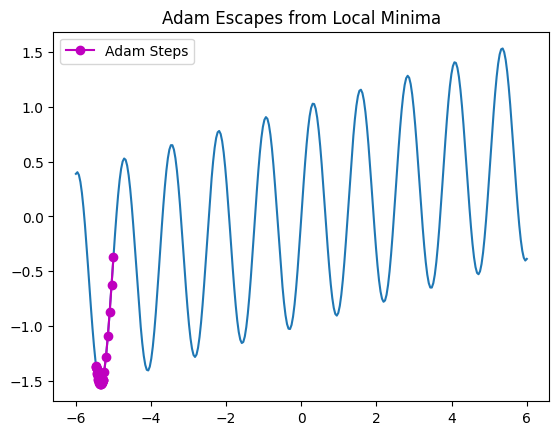

In [14]:
# Parameter setup
x_k = -5
m = 0
v = 0
beta1 = 0.9
beta2 = 0.999
eta = 0.05
eps = 1e-8

# Gradient descent run
history = [x_k]
for t in range(1, 31):
    g = oscillating_grad(x_k)
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * g**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    x_k = x_k - eta * m_hat / (np.sqrt(v_hat) + eps)
    history.append(x_k)

# Gradient descent path plot
x = np.linspace(-6, 6, 300)
plt.plot(x, oscillating_f(x))
plt.plot(history, [oscillating_f(xx) for xx in history], "mo-", label="Adam Steps")
plt.legend()
plt.title("Adam Escapes from Local Minima")
plt.show()

Considering also the previous "flat" function with the same gradient descent starting point $x = -7$ gives the following path:

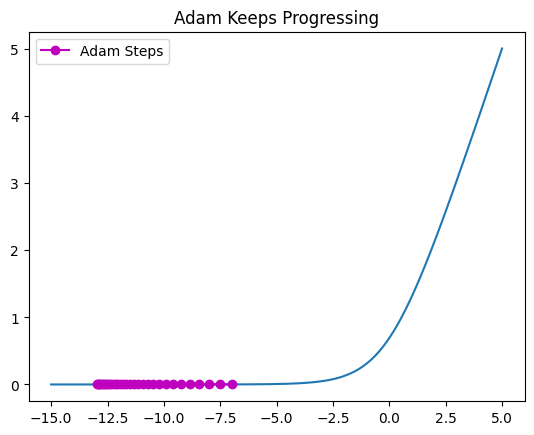

In [15]:
# Parameter setup
x_k = -7.0
m = 0
v = 0
beta1 = 0.9
beta2 = 0.999
eta = 0.5
eps = 1e-8

# Gradient descent run
history = [x_k]
for t in range(1, 31):
    g = flat_grad(x_k)
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * g**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    x_k = x_k - eta * m_hat / (np.sqrt(v_hat) + eps)
    history.append(x_k)

# Gradient descent path plot
x = np.linspace(-15, 5, 300)
plt.plot(x, flat_f(x))
plt.plot(history, flat_f(np.array(history)), "mo-", label="Adam Steps")
plt.title("Adam Keeps Progressing")
plt.legend()
plt.show()

### Pitfall 5: Adam May Not Converge to the *True* Minimum

Adam can overfit, or sometimes doesn't converge to the *exact* minimum, in certain pathological or simple problems, even in convex settings. Further variants like AdamW, AMSGrad, etc., are designed to fix these.

Consider the following "absolute value" function:

$$
f(x) = \lvert x\rvert
$$

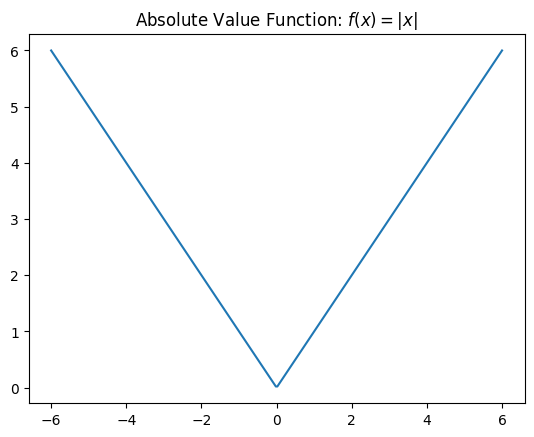

In [16]:
# Function setup
def abs_f(x):
    return np.abs(x)

def abs_grad(x):
    return np.sign(x)

# Function plot
x = np.linspace(-6, 6, 300)
plt.plot(x, abs_f(x))
plt.title("Absolute Value Function: $f(x) = |x|$")
plt.show()

Running gradient descent starting at $x = 5$ gives the following path:

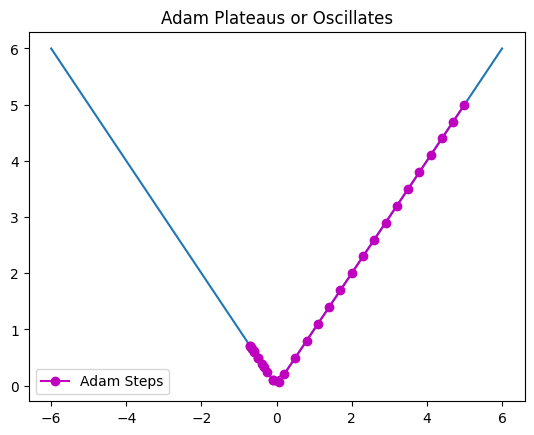

In [17]:
# Parameter setup
x_k = 5.0
m = 0
v = 0
beta1 = 0.9
beta2 = 0.999
eta = 0.3
eps = 1e-8

# Gradient descent run
history = [x_k]
for t in range(1, 31):
    g = abs_grad(x_k)
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * g**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    x_k = x_k - eta * m_hat / (np.sqrt(v_hat) + eps)
    history.append(x_k)

# Gradient descent path plot
x = np.linspace(-6, 6, 300)
plt.plot(x, abs_f(x))
plt.plot(history, [abs_f(xx) for xx in history], "mo-", label="Adam Steps")
plt.legend()
plt.title("Adam Plateaus or Oscillates")
plt.show()

## 6. L-BFGS (Limited-memory BFGS)

While most of the previous optimizers use only the gradient to decide the next step, L-BFGS (Limited-memory BFGS) is a quasi-Newton method which uses both gradient and parameter history to estimate the curvature (second derivative) of the loss surface. On convex (or nearly convex) smooth problems, L-BFGS can converge much faster and more directly than any first-order method.

However, it is typically used with batch gradient descent and doesn't scale as well to large, high-dimensional, or highly non-convex problems, which makes it less suitable for modern deep learning tasks.

Update rule:

$$
x_{k+1} = x_k - \alpha_k H_k^{-1} \nabla f(x_k)
$$

where:
- $x_k$ is the parameter vector at step $k$
- $\nabla f(x_k)$ is the gradient of $f$ at $x_k$
- $\alpha_k$ is the step size
- $H_k^{-1}$ is an **approximation** to the inverse of the Hessian matrix of $f$ at $x_k$

Note:
- Unlike typical gradient descent where the step size $\alpha_k$ is often fixed and fine-tuned, in L-BFGS it is typically determined adaptively via a line search
- Computing the true Hessian and its inverse is expensive. In BFGS the true Hessian is computed and only an approximation to the inverse of the Hessian is used. L-BFGS goes further and never computes the true Hessian, but instead builds an approximation to the inverse of the Hessian using recent inverse approximations.

---


Due to the complexity involved, we'll use an implementation directly from `scipy.optimize`, rather than implementing it ourselves.

Consider the following simple quadratic:

$$
f(x) = (x-3)^2
$$

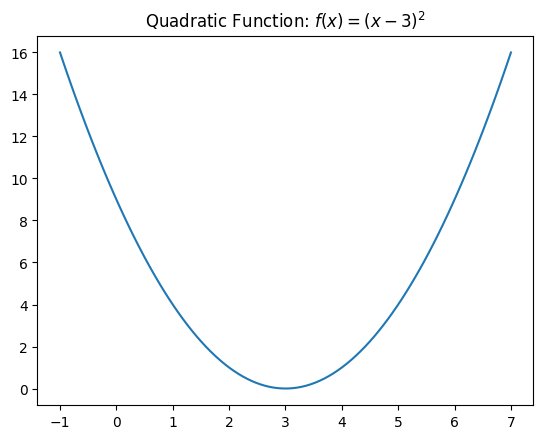

In [18]:
# Function setup
def quad_f(x):
    x = np.asarray(x)
    return (x - 3)**2

def quad_grad(x):
    x = np.asarray(x)
    return 2 * (x - 3)

# Function plot
x = np.linspace(-1, 7, 100)
plt.plot(x, quad_f(x))
plt.title("Quadratic Function: $f(x) = (x-3)^2$")
plt.show()

Running gradient descent starting at $x = 0$ gives the following path:

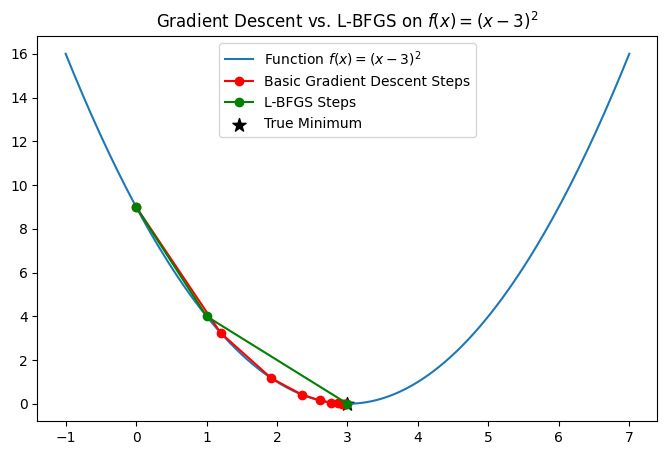

In [19]:
from scipy.optimize import fmin_l_bfgs_b

# Parameter setup for basic gradient descent
x_gd = 0.0
eta = 0.2

# Basic gradient descent run
history_gd = [x_gd]
for _ in range(10):
    x_gd = x_gd - eta * quad_grad(x_gd)
    history_gd.append(x_gd)

# Create L-BFGS history using callback
history_lbfgs = []
def store_lbfgs(x):
    history_lbfgs.append(x[0])

result = fmin_l_bfgs_b(quad_f, np.array([0.0]), fprime=quad_grad, callback=store_lbfgs)
history_lbfgs = [0.0] + history_lbfgs  # Add the starting point for visual parity

# Gradient descent path plot
x = np.linspace(-1, 7, 200)
plt.figure(figsize=(8, 5))
plt.plot(x, quad_f(x), label="Function $f(x) = (x-3)^2$")
plt.plot(history_gd, quad_f(np.array(history_gd)), "ro-", label="Basic Gradient Descent Steps")
plt.plot(history_lbfgs, quad_f(np.array(history_lbfgs)), "go-", label="L-BFGS Steps")
plt.scatter([3], [0], color="black", marker="*", s=100, label="True Minimum")
plt.title("Gradient Descent vs. L-BFGS on $f(x) = (x-3)^2$")
plt.legend()
plt.show()


### Pitfall 6: L-BFGS on Non-Convex or Noisy Problems

L-BFGS struggles on highly non-convex or noisy problems (such as deep neural nets).

Consider the following "wavy" non-convex function:

$$
f(x) = \sin(3x) + 0.1(x-3)^2
$$

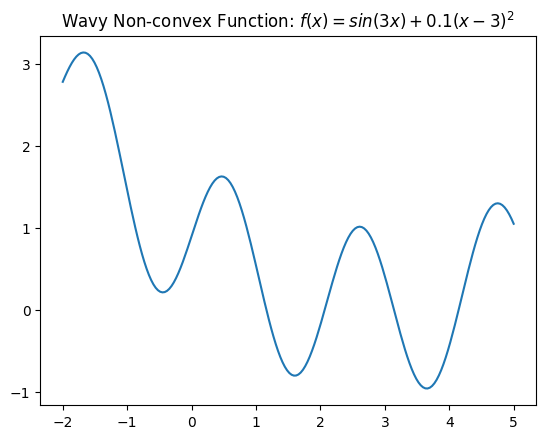

In [20]:
# Function setup
def wavy_f(x):
    return np.sin(3*x[0]) + 0.1 * (x[0] - 3)**2

def wavy_grad(x):
    return np.array([3 * np.cos(3*x[0]) + 0.2 * (x[0] - 3)])

# Function plot
x_ = np.linspace(-2, 5, 200)
plt.plot(x_, [wavy_f([v]) for v in x_])
plt.title("Wavy Non-convex Function: $f(x) = sin(3x) + 0.1(x-3)^2$")
plt.show()

Running gradient descent starting at $x = 0$ gives the following path:

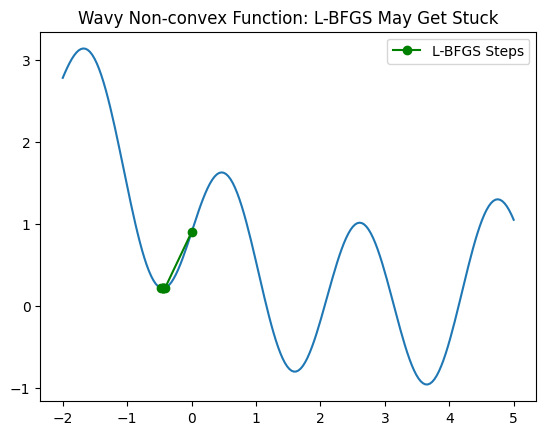

In [21]:
# Create L-BFGS history using callback
history_lbfgs = []
result = fmin_l_bfgs_b(wavy_f, np.array([0.0]), fprime=wavy_grad, callback=store_lbfgs)
history_lbfgs = [0.0] + history_lbfgs  # Add the starting point for visual parity

# Gradient descent path plot
x_ = np.linspace(-2, 5, 200)

plt.plot(x_, [wavy_f([v]) for v in x_])
plt.title("Wavy Non-convex Function: L-BFGS May Get Stuck")
plt.plot(history_lbfgs, [wavy_f([x]) for x in history_lbfgs], "go-", label="L-BFGS Steps")
plt.legend()
plt.show()

## 7. Batch, Stochastic, and Mini-batch Gradient Descent

Gradient descent can also be categorized by **how much data is used per update**:

- **Batch GD:** Uses the full dataset each step (what we've done so far)
- **Stochastic GD (SGD):** Uses a single random data point each step
- **Mini-batch GD:** Uses a small random subset ("mini-batch") each step

---


We compare these below on a simple sum-of-squares regression:

In [22]:
# Generate fake data: y = 2x + noise
np.random.seed(0)
X_data = np.linspace(0, 10, 50)
Y_data = 2 * X_data + np.random.randn(50)

# Parameter setup
x_0 = 0.0
y_0 = 0.0
steps = 30

# Function setup
def mse_loss(w, b, X, Y):
    return np.mean((w*X + b - Y)**2)

def mse_grad(w, b, X, Y):
    N = len(X)
    grad_w = 2/N * np.sum((w*X + b - Y)*X)
    grad_b = 2/N * np.sum(w*X + b - Y)
    return grad_w, grad_b

# Helper function to record parameter path
def run_optimizer(update_fn, w0, b0, steps, X_data, Y_data, loss_fn):
    w, b = w0, b0
    history = [(w, b)]
    losses = [loss_fn(w, b, X_data, Y_data)]
    for _ in range(steps):
        w, b = update_fn(w, b)
        history.append((w, b))
        losses.append(loss_fn(w, b, X_data, Y_data))
    return np.array(history), losses

### Batch Gradient Descent

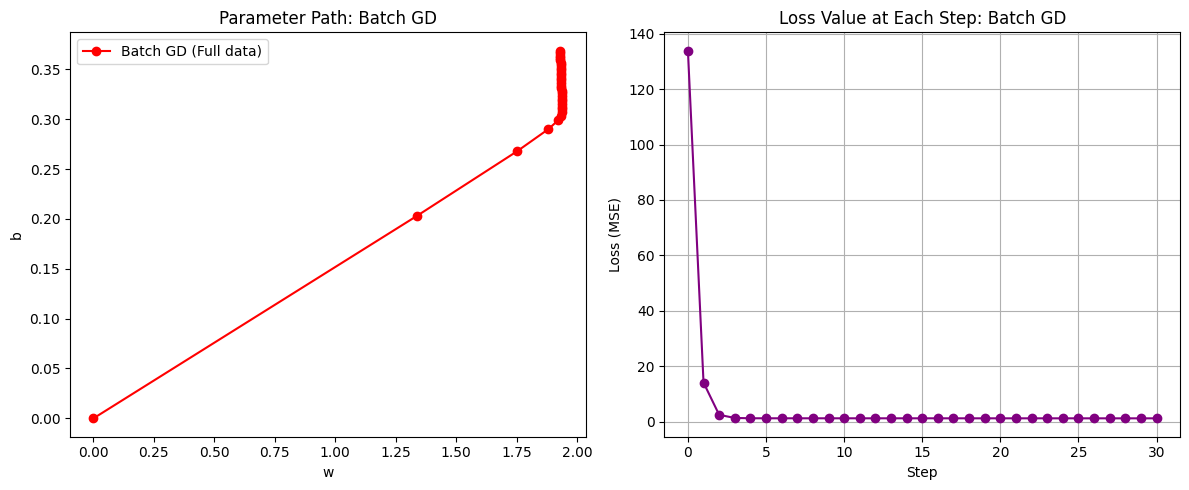

In [23]:
# Parameter setup
eta = 0.01

# Gradient descent run
def batch_update(w, b):
    grad_w, grad_b = mse_grad(w, b, X_data, Y_data)
    return w - eta*grad_w, b - eta*grad_b

batch_hist, batch_losses = run_optimizer(batch_update, x_0, y_0, steps, X_data, Y_data, mse_loss)

# Gradient descent path plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Parameter path subplot
axs[0].plot(batch_hist[:, 0], batch_hist[:, 1], "ro-", label="Batch GD (Full data)")
axs[0].set_xlabel("w")
axs[0].set_ylabel("b")
axs[0].set_title("Parameter Path: Batch GD")
axs[0].legend()

# Loss per step subplot
axs[1].plot(batch_losses, "o-", color="purple")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss (MSE)")
axs[1].set_title("Loss Value at Each Step: Batch GD")
axs[1].grid()

plt.tight_layout()
plt.show()

### Stochastic Gradient Descent (SGD)

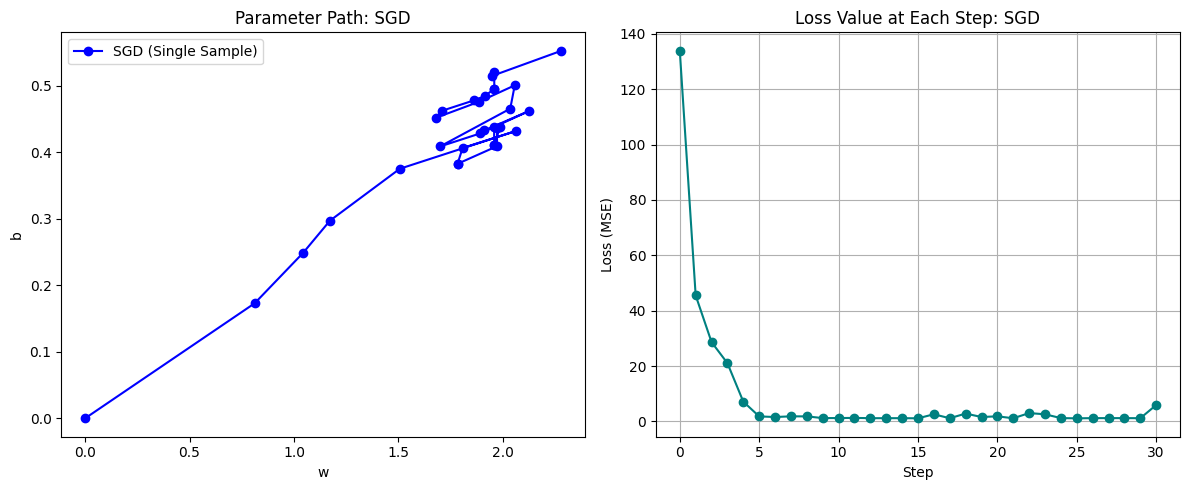

In [24]:
# Parameter setup
eta = 0.01

# Gradient descent run
def sgd_update(w, b):
    idx = np.random.randint(len(X_data))
    X_s, Y_s = X_data[idx:idx+1], Y_data[idx:idx+1]
    grad_w, grad_b = mse_grad(w, b, X_s, Y_s)
    return w - eta*grad_w, b - eta*grad_b

sgd_hist, sgd_losses = run_optimizer(sgd_update, x_0, y_0, steps, X_data, Y_data, mse_loss)

# Gradient descent path plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Parameter path subplot
axs[0].plot(sgd_hist[:, 0], sgd_hist[:, 1], "bo-", label="SGD (Single Sample)")
axs[0].set_xlabel("w")
axs[0].set_ylabel("b")
axs[0].set_title("Parameter Path: SGD")
axs[0].legend()

# Loss per step subplot
axs[1].plot(sgd_losses, "o-", color="teal")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss (MSE)")
axs[1].set_title("Loss Value at Each Step: SGD")
axs[1].grid()

plt.tight_layout()
plt.show()

### Mini-batch Gradient Descent

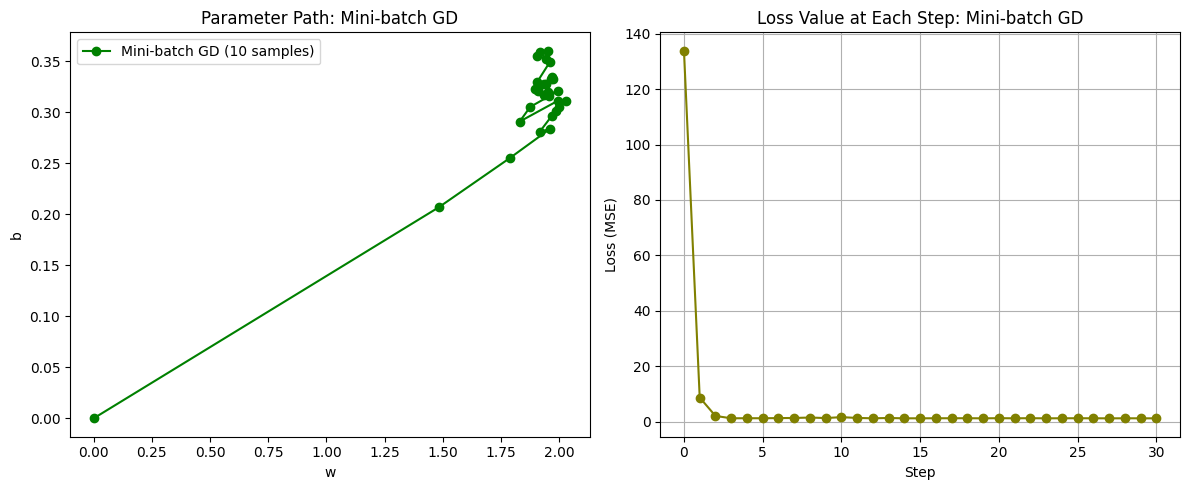

In [25]:
# Parameter setup
batch_size = 10
eta = 0.01

# Gradient descent run
def minibatch_update(w, b):
    idx = np.random.choice(len(X_data), batch_size, replace=False)
    X_mb, Y_mb = X_data[idx], Y_data[idx]
    grad_w, grad_b = mse_grad(w, b, X_mb, Y_mb)
    return w - eta*grad_w, b - eta*grad_b

minibatch_hist, minibatch_losses = run_optimizer(minibatch_update, x_0, y_0, steps, X_data, Y_data, mse_loss)

# Gradient descent path plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Parameter path subplot
axs[0].plot(minibatch_hist[:, 0], minibatch_hist[:, 1], "go-", label="Mini-batch GD (10 samples)")
axs[0].set_xlabel("w")
axs[0].set_ylabel("b")
axs[0].set_title("Parameter Path: Mini-batch GD")
axs[0].legend()

# Loss per step subplot
axs[1].plot(minibatch_losses, "o-", color="olive")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss (MSE)")
axs[1].set_title("Loss Value at Each Step: Mini-batch GD")
axs[1].grid()

plt.tight_layout()
plt.show()

### Observations:
- **Batch GD:** Smoothest path but can be slow with lots of data.
- **SGD:** Noisy but can escape shallow minima.
- **Mini-batch:** In-between; most common in practice.

## 8. Summary Table

| Method           | Category                         | Solves                           | Pitfall (Fails)                    |
|------------------|----------------------------------|----------------------------------|------------------------------------|
| Basic (Batch) GD | 1st Order Optimization Algorithm                              | Simple, stable                   | Slow on large data, local minima   |
| Momentum         | 1st Order Optimization Algorithm | Plateaus                         | Zig-zags in ravines                |
| AdaGrad          | 1st Order Optimization Algorithm | Zig-zags, sparse gradients       | Stops learning (rate shrinks)      |
| RMSProp          | 1st Order Optimization Algorithm | Shrinking learning rate          | Needs tuning, can be unstable      |
| Adam             | 1st Order Optimization Algorithm | Most practical cases             | Overfits, non-convergence          |
| L-BFGS           | 2nd Order Optimization Algorithm | Convex/smooth, rapid convergence | Non-convex, noisy, large scale     |
| Batch GD         | Data Usage per Update            | Simple, stable                   | Slow on large data, local minima   |
| SGD              | Data Usage per Update            | Large datasets, local minima     | Bouncy, unstable                   |
| Mini-batch       | Data Usage per Update            | Speed & stability trade-off      | Still needs batch size tuning      |

**No method is perfect - the best choice depends on the loss function and problem context.**

## 9. Interactive Playground

Change the function, optimizer, or starting point below to see different behaviours.

In [26]:
import ipywidgets as widgets

def run_gd_custom(func_str, grad_str, x0, eta, steps):
    func = eval("lambda x: " + func_str)
    grad = eval("lambda x: " + grad_str)
    x = x0
    hist = [x]
    for _ in range(steps):
        x = x - eta * grad(x)
        hist.append(x)
    xs = np.linspace(min(hist)-2, max(hist)+2, 100)
    plt.plot(xs, [func(xi) for xi in xs])
    plt.title("Custom Gradient Descent Steps")
    plt.show()

# Interactive widget
widgets.interact(run_gd_custom,
                 func_str=widgets.Text(value="(x-2)**2", description="f(x):"),
                 grad_str=widgets.Text(value="2*(x-2)", description="f'(x):"),
                 x0=widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.1, description="Start x0"),
                 eta=widgets.FloatLogSlider(value=0.1, base=10, min=-2, max=0, description="Learning Rate"),
                 steps=widgets.IntSlider(value=10, min=1, max=30, description="Steps"))

interactive(children=(Text(value='(x-2)**2', description='f(x):'), Text(value='2*(x-2)', description="f'(x):")…

<function __main__.run_gd_custom(func_str, grad_str, x0, eta, steps)>

In [27]:
# Preset functions
def quad(x): return (x-2)**2
def quad_grad(x): return 2*(x-2)

def absf(x): return np.abs(x)
def absf_grad(x): return np.sign(x)

def wavy(x): return 0.1*x + np.sin(5*x)
def wavy_grad(x): return 0.1 + 5*np.cos(5*x)

function_map = {
    "Quadratic (x-2)^2": (quad, quad_grad),
    "Absolute Value |x|": (absf, absf_grad),
    "Wavy 0.1x + sin(5x)": (wavy, wavy_grad)
}

def playground(function_choice, optimizer, lr, beta1, beta2, x0, steps):
    f, grad = function_map[function_choice]
    x_k = x0
    history = [x_k]
    m = v = Eg2 = 0.0
    for t in range(1, steps+1):
        g = grad(x_k)
        if optimizer == "GD":
            x_k = x_k - lr * g
        elif optimizer == "Momentum":
            m = beta1 * m + g
            x_k = x_k - lr * m
        elif optimizer == "AdaGrad":
            v += g**2
            x_k = x_k - lr * g / (np.sqrt(v) + 1e-8)
        elif optimizer == "RMSProp":
            Eg2 = beta2 * Eg2 + (1-beta2) * g**2
            x_k = x_k - lr * g / (np.sqrt(Eg2) + 1e-8)
        elif optimizer == "Adam":
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * g**2
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x_k = x_k - lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        history.append(x_k)
    xs = np.linspace(-6, 6, 300)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(xs, [f(x) for x in xs], label="Function")
    plt.plot(history, [f(x) for x in history], "o-", label="Optimizer Path")
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.title("Optimizer Path")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([f(x) for x in history], "o-")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()

# Interactive widget
widgets.interact(
    playground,
    function_choice=widgets.Dropdown(options=list(function_map.keys()), value="Quadratic (x-2)^2", description="Function:"),
    optimizer=widgets.Dropdown(options=["GD", "Momentum", "AdaGrad", "RMSProp", "Adam"], value="GD", description="Optimizer:"),
    lr=widgets.FloatLogSlider(value=0.1, base=10, min=-2, max=0, step=0.01, description="Learning Rate"),
    beta1=widgets.FloatSlider(value=0.9, min=0.0, max=0.99, step=0.01, description="Beta1/Momentum"),
    beta2=widgets.FloatSlider(value=0.9, min=0.0, max=0.999, step=0.01, description="Beta2"),
    x0=widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.1, description="Start x0"),
    steps=widgets.IntSlider(value=15, min=3, max=50, step=1, description="Steps")
)


interactive(children=(Dropdown(description='Function:', options=('Quadratic (x-2)^2', 'Absolute Value |x|', 'W…

<function __main__.playground(function_choice, optimizer, lr, beta1, beta2, x0, steps)>

## 10. References

Cambridge Spark. (n.d.). *Advanced maths for data science*. Retrieved May 29, 2025, from https://cambridgespark.com/

Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep learning*. MIT Press. https://www.deeplearningbook.org/